# Convolutional Neural Networks

Realizaremos un ejercicio descrito en el blog www.aprendemachinelearning.com para hacer reconocimiento de imágenes.

# Importar Librerías

In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


# Cargar set de Imágenes

In [3]:
dirname = os.path.join(os.getcwd(), 'sportimages')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  /Users/jbagnato/github-folders/fastai/sportimages/
/Users/jbagnato/github-folders/fastai/sportimages/golf 1
/Users/jbagnato/github-folders/fastai/sportimages/basket 9768
/Users/jbagnato/github-folders/fastai/sportimages/tenis 8823
/Users/jbagnato/github-folders/fastai/sportimages/natacion 8937
/Users/jbagnato/github-folders/fastai/sportimages/ciclismo 5172
/Users/jbagnato/github-folders/fastai/sportimages/beisball 7533
/Users/jbagnato/github-folders/fastai/sportimages/futbol 7752
/Users/jbagnato/github-folders/fastai/sportimages/americano 7617
/Users/jbagnato/github-folders/fastai/sportimages/f1 9348
/Users/jbagnato/github-folders/fastai/sportimages/boxeo 5053
Directorios leidos: 10
Imagenes en cada directorio [9769, 8823, 8937, 5172, 7533, 7752, 7617, 9348, 5053, 7124]
suma Total de imagenes en subdirs: 77128


# Creamos las etiquetas

In [4]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  77128


In [5]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 golf
1 basket
2 tenis
3 natacion
4 ciclismo
5 beisball
6 futbol
7 americano
8 f1
9 boxeo


In [6]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


# Creamos Sets de Entrenamiento y Test

In [7]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (61702, 21, 28, 3) (61702,)
Testing data shape :  (15426, 21, 28, 3) (15426,)


Text(0.5,1,'Ground Truth : 9')

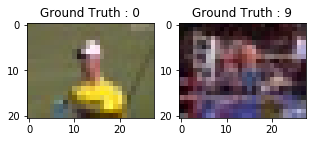

In [8]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

In [9]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

## Hacemos el One-hot Encoding para la red

In [10]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 0
After conversion to one-hot: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [11]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [12]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(49361, 21, 28, 3) (12341, 21, 28, 3) (49361, 10) (12341, 10)


# Creamos el modelo de CNN

In [13]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 6 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [14]:
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))

sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

In [15]:
sport_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 21, 28, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 21, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4928)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                157728    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)                0         
__________

In [16]:
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes

In [17]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
# como ejemplo, en mi Macbook pro tarda 4 minutos
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Train on 49361 samples, validate on 12341 samples
Epoch 1/6
49361/49361 [==============================] - 40s 814us/step - loss: 1.5198 - acc: 0.4897 - val_loss: 1.0611 - val_acc: 0.7136
Epoch 2/6
49361/49361 [==============================] - 38s 775us/step - loss: 1.2002 - acc: 0.6063 - val_loss: 0.8987 - val_acc: 0.7717
Epoch 3/6
49361/49361 [==============================] - 43s 864us/step - loss: 1.0886 - acc: 0.6469 - val_loss: 0.8078 - val_acc: 0.7977
Epoch 4/6
49361/49361 [==============================] - 41s 832us/step - loss: 1.0166 - acc: 0.6720 - val_loss: 0.7512 - val_acc: 0.8180
Epoch 5/6
49361/49361 [==============================] - 36s 725us/step - loss: 0.9647 - acc: 0.6894 - val_loss: 0.7033 - val_acc: 0.8323
Epoch 6/6
49361/49361 [==============================] - 40s 802us/step - loss: 0.9258 - acc: 0.7032 - val_loss: 0.6717 - val_acc: 0.8379


In [18]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("sports_mnist.h5py")

# Evaluamos la red

In [19]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

15426/15426 [==============================] - 5s 310us/step


In [20]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.6687967825782881
Test accuracy: 0.8409179307662388


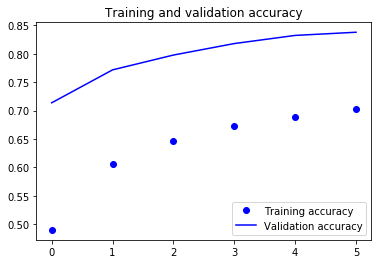

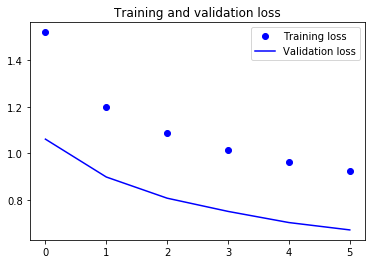

In [21]:
accuracy = sport_train.history['acc']
val_accuracy = sport_train.history['val_acc']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [22]:
predicted_classes2 = sport_model.predict(test_X)

In [23]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [24]:
predicted_classes.shape, test_Y.shape

((15426,), (15426,))

# Aprendamos de los errores: Qué mejorar

Found 12972 correct labels


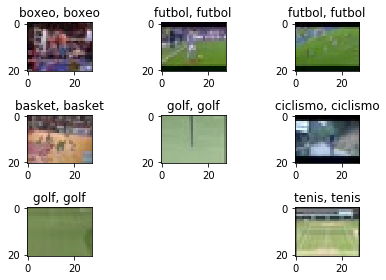

In [25]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 2454 incorrect labels


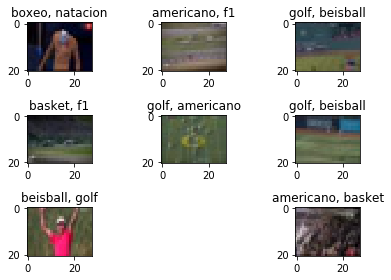

In [26]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [27]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.71      0.93      0.80      1985
    Class 1       0.81      0.90      0.85      1832
    Class 2       0.97      1.00      0.99      1783
    Class 3       0.94      0.94      0.94      1018
    Class 4       0.96      0.99      0.97      1513
    Class 5       0.84      0.77      0.80      1526
    Class 6       0.95      0.78      0.86      1490
    Class 7       0.69      0.65      0.67      1878
    Class 8       0.74      0.37      0.50      1002
    Class 9       0.88      0.93      0.91      1399

avg / total       0.84      0.84      0.83     15426



# Prediccion de una nueva imagen

In [ ]:
from skimage.transform import resize

images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = ['test/golf_0113.jpg']

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (21, 28),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])